In [1]:
# Parameters
bucket_name = "churn-model-prediction"
source_blob_name = "Telecom-Customer-Churn.csv"
destination_file_name = "/home/jupyter/ChurnPropensity/dataset1/Telecom-Customer-Churn.csv"


In [2]:
# Parameters
bucket_name = "default_bucket"
source_blob_name = "default_blob.csv"
destination_file_name = "default_path.csv"


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score

In [4]:
from google.cloud import storage

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(f"Blob {source_blob_name} downloaded to {destination_file_name}.")

#
bucket_name = 'churn-model-prediction'
source_blob_name = 'Telecom-Customer-Churn.csv'
destination_file_name = '/home/jupyter/ChurnPropensity/dataset1/Telecom-Customer-Churn.csv'

download_blob(bucket_name, source_blob_name, destination_file_name)


Blob Telecom-Customer-Churn.csv downloaded to /home/jupyter/ChurnPropensity/dataset1/Telecom-Customer-Churn.csv.


In [5]:
#df = pd.read_csv('Telecom-Customer-Churn.csv',index_col = 'customerID')
df = pd.read_csv('dataset1/Telecom-Customer-Churn.csv')

In [6]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.shape

(7043, 21)

In [8]:
df.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [9]:
df_columns = df.columns.tolist()
for column in df_columns:
    unique_values = df[column].unique()
    print(f"{column} unique values: {unique_values}")


customerID unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender unique values: ['Female' 'Male']
SeniorCitizen unique values: [0 1]
Partner unique values: ['Yes' 'No']
Dependents unique values: ['No' 'Yes']
tenure unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService unique values: ['No' 'Yes']
MultipleLines unique values: ['No phone service' 'No' 'Yes']
InternetService unique values: ['DSL' 'Fiber optic' 'No']
OnlineSecurity unique values: ['No' 'Yes' 'No internet service']
OnlineBackup unique values: ['Yes' 'No' 'No internet service']
DeviceProtection unique values: ['No' 'Yes' 'No internet service']
TechSupport unique values: ['No' 'Yes' 'No internet service']
StreamingTV unique values: ['No' 'Yes' 'No internet service']
StreamingMovie

In [10]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [11]:
df.describe()

#below we can see senior citizen has categorical data
#The average customer stayed in the company is 32 months and 75% of customer has a tenure of 55 month
#Average monthly charges are USD 64.76 and 25% of customers pay more than USD 89.85

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
#errors='coerce' parameter -invalid parsing will be set to NaN (Not a Number)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [14]:
 # to check the nan value which coerce has replaced if any value found that cannot be converted to numeric

df.isnull().sum() 

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [15]:
df.Churn.value_counts()
#here we can see the data is much imbalanced so we would be needing resampling of the data
#to evaluate the model

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [16]:

x=list(df.Churn.value_counts())
print('No' , x[0]/(x[0]+x[1])*100 ,'%')
print('Yes' , x[1]/(x[0]+x[1])*100 ,'%')
df['Churn'].value_counts()

No 73.4630129206304 %
Yes 26.536987079369588 %


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [17]:
df.dropna(inplace = True)
df2=df.iloc[:,1:]  #----------it will drop the first column that is customer ID which is irrelevent
#print(df2) it will print whole data set except first column

In [18]:
#Convertin the predictor variable in a binary numeric variable
#df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
#df2['Churn'].replace(to_replace='No',  value=0, inplace=True)


# Convert the predictor variable into a binary numeric variable
df2['Churn'] = df2['Churn'].replace({'Yes': 1, 'No': 0})
df2['Churn'] = df2['Churn'].infer_objects(copy=False)



/var/tmp/ipykernel_87427/3818874799.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['Churn'] = df2['Churn'].replace({'Yes': 1, 'No': 0})


In [19]:
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,True,False,False,True,True,...,False,True,False,False,False,True,False,False,True,False
1,0,34,56.95,1889.50,0,False,True,True,False,True,...,False,False,True,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,False,True,True,False,True,...,False,True,False,False,False,True,False,False,False,True
3,0,45,42.30,1840.75,0,False,True,True,False,True,...,False,False,True,False,True,False,True,False,False,False
4,0,2,70.70,151.65,1,True,False,True,False,True,...,False,True,False,False,False,True,False,False,True,False


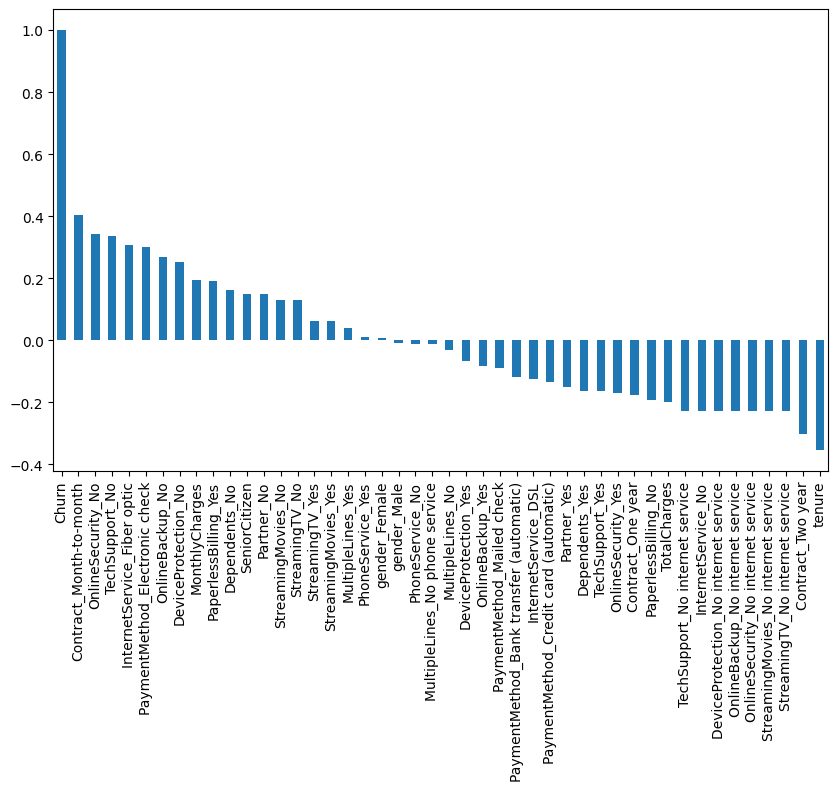

In [20]:
plt.figure(figsize=(10,6))
df_dummies.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
#plt.savefig("dataVisualisation/correlation.png", dpi=300)
plt.show()

In [21]:
#data exploration

In [22]:
# for demographics data 

In [23]:
print(len(df_dummies))

7032


In [24]:
print(df['gender'].value_counts()*100.0/ len(df))

gender
Male      50.469283
Female    49.530717
Name: count, dtype: float64


Text(0.5, 1.0, 'Gender Distribution')

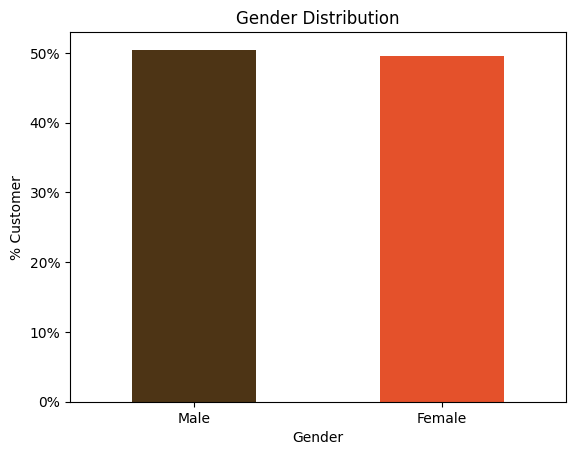

In [25]:
colors = ['#4D3415','#E4512B']
ax= (df['gender'].value_counts()*100 /len(df)).plot(kind='bar',rot=0 ,color=colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())  #--------it will format the yaxis into the percentage format
#ax.xaxis.set_major_formatter(mtick.PercentFormatter())

ax.set_xlabel('Gender')
ax.set_ylabel('% Customer')
ax.set_title('Gender Distribution')
#plt.savefig("dataVisualisation/genderDistribution.png", dpi=300)

In [26]:

df2[['gender','Churn']].groupby(['gender']).mean()

,Churn
gender,
Female,0.269595
Male,0.262046


In [27]:
#above reflects that about 26% each male and female have churned

In [28]:
print(df['SeniorCitizen'].value_counts()*100.0/ len(df))

SeniorCitizen
0    83.759954
1    16.240046
Name: count, dtype: float64


Text(0.5, 1.0, '% of senior citizen')

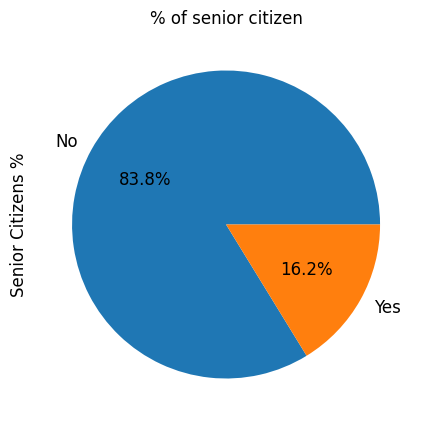

In [29]:
ax = (df['SeniorCitizen'].value_counts()*100.0 / len(df))\
.plot.pie(autopct='%.1f%%', labels = ['No' , 'Yes'] ,figsize =(5,5) , fontsize = 12) 

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens %' ,fontsize = 12)

ax.set_title('% of senior citizen' , fontsize = 12)
#plt.savefig("dataVisualisation/SeniorCitizenDistribution.png", dpi=300)

In [30]:
df2[['Partner' , 'Churn']].groupby(['Partner']).mean()

,Churn
Partner,
No,0.329761
Yes,0.197171


In [31]:
# above indicate that 32.98% of customers without a partner have churned.
#and 19.72% of customers with a partner have churned.

In [32]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [33]:
#print(df.columns.value_counts().shape[0])

In [34]:
columns = df.columns  #will findout the features which would be having the 2 values exact
binary_cols = []

for col in columns:
    if df[col].value_counts().shape[0] ==2:
        binary_cols.append(col)

binary_cols  #categorical features with two classes

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [35]:
df2[['Dependents' , 'Churn']].groupby(['Dependents']).mean()

,Churn
Dependents,
No,0.312791
Yes,0.155312


In [36]:
df2[['PhoneService' , 'Churn']].groupby(['PhoneService']).mean()

,Churn
PhoneService,
No,0.250000
Yes,0.267475


In [37]:
df2[['PaperlessBilling' , 'Churn']].groupby(['PaperlessBilling']).mean()

,Churn
PaperlessBilling,
No,0.163757
Yes,0.335893


In [38]:
print(df['InternetService'].value_counts())

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64


Text(0.5, 0, 'InternetService')

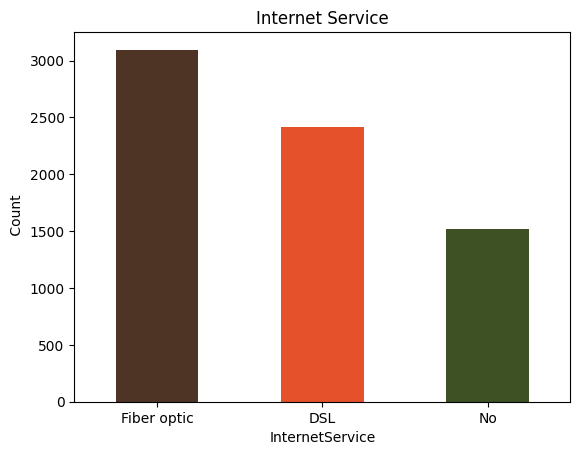

In [39]:
#now we will analyse the features which is having more than 2 features:
#internet service
colors = ['#4D3425','#E4512B' ,'#3E5124']
#ax=(df['InternetService'].value_counts()*100.0 /len(df)).plot(kind='bar',stacked=True,rot=0,color=colors)
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax=(df['InternetService'].value_counts()).plot(kind='bar',stacked = True,rot=0,color=colors)


ax.set_ylabel(' Count' )
ax.set_title('Internet Service')

ax.set_xlabel('InternetService')
#plt.savefig("dataVisualisation/InternetServiceDistribution.png", dpi=300)

In [40]:
df2[['InternetService' , 'Churn']].groupby('InternetService').mean()

,Churn
InternetService,
DSL,0.189983
Fiber optic,0.418928
No,0.074342


Text(0.5, 1.0, 'StreamingTV')

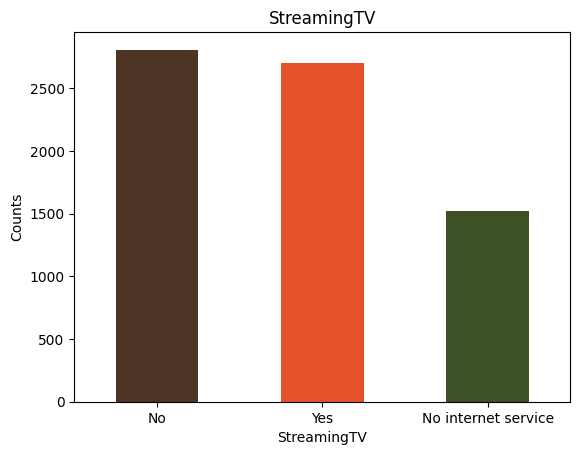

In [41]:
colors = ['#4D3425','#E4512B' ,'#3E5124']
ax=(df['StreamingTV'].value_counts()).plot(kind='bar',color=colors,rot=0)
ax.set_ylabel('Counts')
ax.set_title('StreamingTV')
#plt.savefig("dataVisualisation/StreamingTVDistribution.png", dpi=300)

In [42]:
df2[['StreamingTV' , 'Churn']].groupby('StreamingTV').mean()

,Churn
StreamingTV,
No,0.335351
No internet service,0.074342
Yes,0.301147


Text(0.5, 1.0, 'TechSupport')

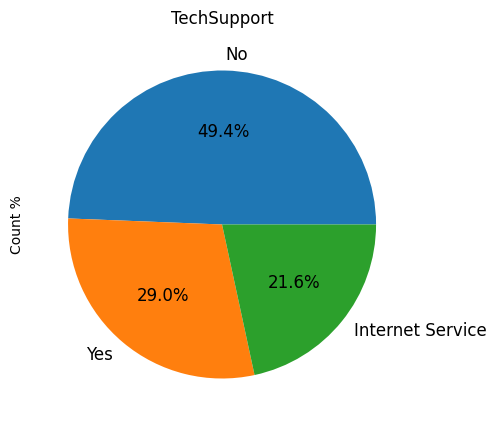

In [43]:
ax = (df['TechSupport'].value_counts()*100.0 / len(df))\
.plot.pie(autopct='%.1f%%', labels = ['No' , 'Yes' , 'Internet Service'] ,figsize =(5,5) , fontsize = 12) 
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Count %')
ax.set_title('TechSupport')
#plt.savefig("dataVisualisation/TechSupportDistribution.png", dpi=300)

In [44]:
df2[['TechSupport' ,'Churn']].groupby('TechSupport').mean()

,Churn
TechSupport,
No,0.416475
No internet service,0.074342
Yes,0.151961


Text(0.5, 0, 'Online_Security')

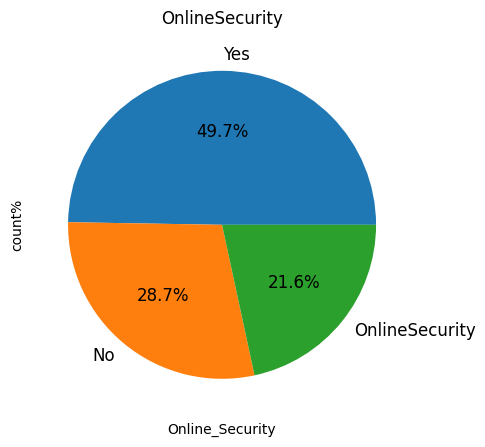

In [45]:
ax = (df['OnlineSecurity'].value_counts()*100.0/len(df))\
.plot.pie(autopct='%.1f%%', labels=['Yes','No','OnlineSecurity'],figsize = (5,5),fontsize=12)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('count%')
ax.set_title('OnlineSecurity')
ax.set_xlabel('Online_Security')
#plt.savefig("dataVisualisation/Online_SecurityDistribution.png", dpi=300)

In [46]:
df2[['OnlineSecurity' , 'Churn']].groupby('OnlineSecurity').mean()

,Churn
OnlineSecurity,
No,0.417787
No internet service,0.074342
Yes,0.146402


In [ ]:
ax=sns.displot(df['tenure'],binwidth=2,color = 'red',bins=30,kde = True)
plt.xlabel('Tenure (months)')
plt.ylabel('# of Customers')
plt.title('# of Customers by their tenure')
#plt.savefig("dataVisualisation/TenureDistribution.png", dpi=300)

In [ ]:
ax=df['Contract'].value_counts().plot(kind='bar',rot=0,width=0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')
#plt.savefig("dataVisualisation/ContractDistribution.png", dpi=300)

In [ ]:
ax1 = sns.displot(df[df['Contract']=='Month-to-month']['tenure'] , binwidth=2,color = 'lightblue',bins=30)
plt.xlabel('Tenure (months)')
plt.ylabel('# of Customers')
plt.title('Month to Month Contract')
#plt.savefig("dataVisualisation/Month_to_MonthDistribution.png", dpi=300)


In [ ]:
#the customer who is taking the month to month contract are having the short tenures and less loyal

In [ ]:

ax1=sns.displot(df[df['Contract']=='One year']['tenure'],binwidth=2,color='red',bins=30)

plt.xlabel('Tenure (months)')
plt.ylabel('# of Customers')
plt.title('One Year Contract')
#plt.savefig("dataVisualisation/oneYearDistribution.png", dpi=300)

In [ ]:
ax2=sns.displot(df[df['Contract']=='Two year']['tenure'],binwidth=2,color='green',bins=30)
plt.xlabel('Tenure (months)')
plt.ylabel('# of Customers')
plt.title('Two Year Contract')
#plt.savefig("dataVisualisation/two_YearDistribution.png", dpi=300)

In [ ]:
df.columns.values

In [ ]:
columns = df.columns  #will findout the features which would be having the 2 values exact
binary_cols1 = []

for col in columns:
    if df[col].value_counts().shape[0] ==3:
        binary_cols1.append(col)

binary_cols1  #categorical features with two classes

In [ ]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,20))
for i, item in enumerate(services):
    if i < 3:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = df[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)
  #  plt.savefig("dataVisualisation/PhoneServiceDistribution.png", dpi=300)
   # plt.savefig("dataVisualisation/MultipleLinesDistribution.png", dpi=300)
    #plt.savefig("dataVisualisation/OnlineBackupDistribution.png", dpi=300)
    #plt.savefig("dataVisualisation/DeviceProtectionDistribution.png", dpi=300)
    #plt.savefig("dataVisualisation/StreamingMoviesDistribution.png", dpi=300)


In [ ]:
df[['MonthlyCharges','TotalCharges']].plot.scatter(x='MonthlyCharges',y='TotalCharges')
#plt.savefig("dataVisualisation/month_VS_totalCharges.png", dpi=300)

In [ ]:
#now we will ckeck the skewness of our predicted data
# and will check the behaviour of rest of the field with churn

In [ ]:

x=list(df.Churn.value_counts())
print('No' , x[0]/(x[0]+x[1])*100 ,'%')
print('Yes' , x[1]/(x[0]+x[1])*100 ,'%')
df['Churn'].value_counts()

In [ ]:
colors = ['#4D3425','#E4512B']

ax=(df['Churn'].value_counts()*100.0/len(df)).plot(kind='bar' , color=colors,rot=0,stacked=True,fig=(4,2))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)
#plt.savefig("dataVisualisation/ChurnRate.png", dpi=300)

In [ ]:
# now we will do eda of all fields with churn

In [ ]:
sns.boxplot(x=df.Churn, y=df.tenure)
#plt.savefig("dataVisualisation/Tenure_vs_churn.png", dpi=300)

In [ ]:
colors = ['#4D3425','#E4512B']

contract_churn=df.groupby(['Contract','Churn']).size().unstack()
print(contract_churn)

In [ ]:
colors = ['#4D3425','#E4512B']

contract_churn=df.groupby(['Contract','Churn']).size().unstack()

print(contract_churn.T)

In [ ]:
colors = ['#4D3425','#E4512B']
contract_churn = df.groupby(['Contract','Churn']).size().unstack(level=0)

print(contract_churn*100.0/ contract_churn.sum())

In [ ]:

colors = ['#4D3425', '#E4512B', '#1F77B4', '#FF7F0E']

contract_churn = df.groupby(['Contract','Churn']).size().unstack()

ax=(contract_churn.T*100.0/ contract_churn.T.sum()).T.plot(kind='bar',width=0.3,stacked=True,rot=0,figsize=(10,6),color=colors)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.legend(loc='best',prop={'size':10},title = 'Churn')

ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
#plt.savefig("dataVisualisation/churn_vs_contractType.png", dpi=300)

In [ ]:
df.MonthlyCharges.value_counts()

In [ ]:
ax=sns.kdeplot(df.MonthlyCharges[(df['Churn'] == 'No')],color="Red", shade = True)

ax=sns.kdeplot(df.MonthlyCharges[(df['Churn'] == 'Yes')],color='blue',shade=True)

ax.legend(["Not Churn","Churn"],loc='upper right')

ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')
#plt.savefig("dataVisualisation/Monthly_ChargesDistribution.png", dpi=300)

In [ ]:
#we can see that highest % of customer churned when the monthly charges are high
#below method also we can use it to visualise the same using histogram

In [ ]:

# Define the data
no_churn = df.MonthlyCharges[df['Churn'] == 'No']
yes_churn = df.MonthlyCharges[df['Churn'] == 'Yes']

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(no_churn, bins=30, color='red', alpha=0.5, label='Not Churn')
plt.hist(yes_churn, bins=30, color='blue', alpha=0.5, label='Churn')

# Add labels and title
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Charges by Churn')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
df.TotalCharges.value_counts().head()

In [ ]:

# Define the data
no_churn = df.TotalCharges[df['Churn'] == 'No']
yes_churn = df.TotalCharges[df['Churn'] == 'Yes']

# Create the plot
plt.figure(figsize=(10, 6))

# Plot histograms
plt.hist(no_churn, bins=30, color='red', alpha=0.5, label='Not Churn')
plt.hist(yes_churn, bins=30, color='blue', alpha=0.5, label='Churn')

# Add labels and title
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')
plt.title('Distribution of TotalCharges by Churn')
plt.legend(loc='upper right')

# Show the plot
plt.show()

#result --churn rate is high when total charges are low
#plt.savefig("dataVisualisation/Totaol_charges_Distribution.png", dpi=300)

In [ ]:
df2[['SeniorCitizen','Churn']].groupby('SeniorCitizen').mean()

In [ ]:
colors = ['#4D3425','#E4512B']

sen_churn=df.groupby(['SeniorCitizen','Churn']).size().unstack()
ax=(sen_churn.T*100.0/sen_churn.T.sum()).T.plot(kind='bar',stacked=True,rot=0,width = 0.2,figsize=(8,6),color=colors)

ax.legend(['No','Yes'],title='Churn',loc='center')

ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#plt.savefig("dataVisualisation/churn_vs_seniority.png", dpi=300)

In [ ]:
df_dummies = pd.get_dummies(df2)
df_dummies.head()

In [ ]:
#now  EDA is done  now we will go with some predictive models and compare their performances.
# We will use the data frame where we had created dummy variables

#1. Logistic Regression

In [ ]:
Y=df_dummies['Churn'].values
print(Y)

In [ ]:
X=df_dummies.drop(columns=['Churn'])

In [ ]:
"""The fit(data) method is used to compute the mean and std dev for a given feature so that it can be used further for scaling.
The transform(data) method is used to perform scaling using mean and std dev calculated using the .fit() method.
The fit_transform() method does both fit and transform."""

In [ ]:
Y=df_dummies['Churn'].values
X=df_dummies.drop(columns=['Churn'])
from sklearn.preprocessing import MinMaxScaler

features=X.columns.values
scaler=MinMaxScaler(feature_range=(0,1))
model=scaler.fit(X) #will find mean and sd
scaled_model=model.transform(X)  #will transform the data into same range i.e., scaling of data will be done
X.columns=features


In [ ]:
print(features)

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.3,random_state=101)

In [ ]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', max_iter=200)
result = model.fit(X_train, y_train)


In [ ]:
import joblib

# Save the model to a file
joblib.dump(model, 'model.joblib')

In [ ]:
model = joblib.load('model.joblib')

In [ ]:
from sklearn import metrics

prediction_test=model.predict(X_test) #
#y_prediction_test_proba = model.predict_proba(X_test)
print('test :',metrics.accuracy_score(y_test,prediction_test))
prediction_test1=model.predict(X_train)
print('train :',metrics.accuracy_score(y_train,prediction_test1))

In [ ]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
    cm = confusion_matrix(y_pred,y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot()
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.show()
    
    print(f"Accuracy Score Test = {accuracy_score(y_pred,y_test)}")
    print(f"Accuracy Score Train = {classifier.score(X_train,y_train)}")
    return print("\n")

In [ ]:
confusion_matrix_plot(X_train,y_train,X_test,y_test, prediction_test,model,"Logistic Regression")

#plt.savefig("dataVisualisation/logistic_confusion_matrix.png", dpi=300)

In [ ]:
model.coef_[0]

In [ ]:
Columns=X.columns.values
print(Columns)

In [ ]:

weights = pd.Series(model.coef_[0], index=X.columns.values)

# Sort and plot the top 10 coefficients as a line plot
weights.sort_values(ascending=False)[:10].plot(kind='line', marker='o')
plt.title('Top 10 Feature Weights')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.show()



In [ ]:
weights=pd.Series(model.coef_[0],index=X.columns.values)

print(weights.sort_values(ascending=False)[:10].plot(kind='bar'))
#plt.savefig("dataVisualisation/weights_first_10.png", dpi=300)

In [ ]:
weights=pd.Series(model.coef_[0],index=X.columns.values)
print(weights.sort_values(ascending=False)[-10:].plot(kind='bar'))
#plt.savefig("dataVisualisation/wt_last_10.png", dpi=300)
#Negative relation means that likeliness of churn decreases with that variable

In [ ]:
first_X_test_record = X_test.iloc[1]
first_y_test_record = y_test[1]
print(first_X_test_record)
print(first_y_test_record)



In [ ]:

# Extracting one record from X_test and reshaping it
single_X_test_record = X_test.iloc[1].values.reshape(1, -1) # Reshape to 2D array

# Making the prediction
prediction_test = model.predict(single_X_test_record)

print(prediction_test)


In [ ]:

import joblib

# Save the model to a file
joblib.dump(model, 'model.joblib')


In [ ]:
# Load the model from the file
model = joblib.load('model.joblib')


In [ ]:

import sklearn
print(sklearn.__version__)


In [ ]:

!pip install google-cloud-storage


In [ ]:
import os
from google.cloud import storage

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {destination_blob_name}.")

def upload_directory(bucket_name, source_directory, destination_directory):
    """Uploads all files in a directory to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    for root, _, files in os.walk(source_directory):
        for file in files:
            file_path = os.path.join(root, file)
            blob_path = os.path.join(destination_directory, file)
            blob = bucket.blob(blob_path)
            blob.upload_from_filename(file_path)
            print(f"File {file_path} uploaded to {blob_path}.")

# Example usage
bucket_name = 'churn-model-prediction'
source_directory = '/home/jupyter/ChurnPropensity/dataVisualisation'
destination_directory = 'VizualisationForLooker'

upload_directory(bucket_name, source_directory, destination_directory)


In [ ]:
#Random forest ---------------------------------------------------------------------------------------------------

from sklearn import metrics
y=df_dummies['Churn'].values
X=df_dummies.drop(columns=['Churn'])
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=101)
model_rf=RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1, random_state =50, max_features = "sqrt",max_leaf_nodes = 30)
result=model_rf.fit(X_train, y_train)
prediction_test=model_rf.predict(X_test)
print(metrics.accuracy_score(y_test, prediction_test))
